## 特征集
**学习目标**：创建一个包含更少特征但是效果和更复杂的特征集一样出色的集合。

### 设置
加载加州住房数据集

In [1]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_df = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv",
                                   sep=',')
california_housing_df = california_housing_df.reindex(np.random.permutation(california_housing_df.index))

In [2]:
# 预处理特征
def preprocess_features(california_housing_df):
    """预处理房价的DataFrame，准备输入特征,添加人为特征
    Args:
        california_housing_df: 包含加州房价数据的df
    Returns:
        包含处理后特征的DataFrame
    """
    selected_features = california_housing_df[["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    # 创建额外的特征
    processed_features["rooms_per_person"] = (california_housing_df["total_rooms"] / california_housing_df["population"])
    return processed_features

# 预处理目标
def preprocess_targets(california_housing_df):
    """从加州房价DataFrame准备目标特征，即标签
    Args:
        california_housing_dataframe: 包含加州房价数据的df
    Returns:
        包含目标标签的df
    """
    output_targets = pd.DataFrame()
    # 将目标标签的值缩放
    output_targets["median_house_value"] = (california_housing_df["median_house_value"] / 1000.0)
    return output_targets


In [4]:

# 选择前12000/17000用于训练
training_examples = preprocess_features(california_housing_df.head(12000))
training_targets = preprocess_targets(california_housing_df.head(12000))

# 选择最后的5000用于验证
validation_examples = preprocess_features(california_housing_df.tail(5000))
validation_targets = preprocess_targets(california_housing_df.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2645.4,538.0,1429.3,500.5,3.9,2.0
std,2.1,2.0,12.6,2211.0,424.4,1172.9,387.6,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1458.8,296.0,792.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2127.0,434.0,1167.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3127.2,645.0,1716.0,602.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.3,2639.6,542.8,1430.1,502.9,3.9,2.0
std,2.2,2.0,12.5,2103.8,414.6,1085.4,377.2,1.9,1.3
min,32.6,-124.3,1.0,18.0,3.0,8.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1466.8,298.8,784.0,282.0,2.5,1.5
50%,34.3,-118.5,28.0,2127.0,432.0,1167.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3193.0,661.0,1737.0,611.0,4.8,2.3
max,41.9,-114.3,52.0,27700.0,4407.0,15037.0,4072.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.8
std,115.9
min,15.0
25%,120.4
50%,181.1
75%,265.2
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.2
std,116.2
min,15.0
25%,118.1
50%,178.4
75%,264.6
max,500.0


### 任务1. 构建良好的特征集
如果只使用少数的特征如(2-3个)，我们能获得多好的效果？

**相关矩阵**展现了两两比较的相关性。这里的相关性被定义为Pearson相关系数，即两个变量的协方差和标准差的商。

其相关性值范围在\[-1, +1\]之间，具有以下含义：

|完全负相关|不相关|完全正相关|
|:---:|:---:|:---:|
|-1.0|0|+1.0|

In [10]:
correlation_mx_df = training_examples.copy()
correlation_mx_df["target"] = training_targets["median_house_value"]
correlation_mx_df.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.1
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.3,0.7
rooms_per_person,0.2,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.3,1.0,0.2
target,-0.1,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


通常情况下，我们需要：
- 具有与目标密切相关的特征
- 相互之间相关性不太密切的特征。
- 也可以构建合成特征

In [11]:
def my_input_fn(features, targets, batch_size=1,shuffle=True, num_epochs=None):
    """使用多个特征训练一个线性回归器
    Args:
        features: 特征的DataFrame
        targets: 目标的DataFrame
        batch_size: 传递给模型的批大小
        shuffle: 是否打乱数据
        num_epochs: 数据重复的epochs数
    Returns:
        下一批数据元组(features, labels)
    """
    # 转换DataFrame到numpy数组
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # 构建数据集
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
def construct_feature_columns(input_features):
    """构建特征列
    Args:
        input_features: 数值特征的名字
    Returns:
        特征列集
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [15]:
def train_model(learning_rate, 
                steps, 
                batch_size, 
                training_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), 
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        
        # 计算训练和验证的损失
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    return linear_regressor

Start training...
RMSE (on training data): 
period 00 : 165.87
period 01 : 125.87
period 02 : 118.85
period 03 : 116.96
period 04 : 116.37
period 05 : 115.43
period 06 : 114.99
period 07 : 114.54
period 08 : 113.87
period 09 : 114.79
Model training finished!


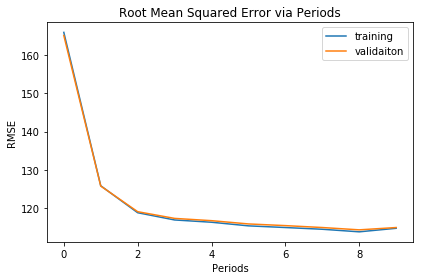

In [16]:
# 训练模型
minimal_features = ["median_income", "latitude"]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(learning_rate=0.001, 
                steps=500, 
                batch_size=5,
                training_examples=minimal_training_examples, 
                training_targets=training_targets,
               validation_examples=minimal_validation_examples,
               validation_targets=validation_targets)

### 任务2. 更好地利用纬度信息
绘制纬度(latitude)和房价中值(median_house_value)的图形发现两者确实不存在线性关系。但是图中的峰值与洛杉矶和旧金山的位置相对应。

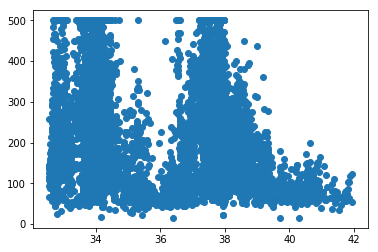

In [18]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

**尝试去创建一些更好利用纬度的合成特征**
- 把纬度特征变为映射为到旧金山的距离 |latitude-38|
- 把纬度分10个桶

In [36]:
# process 1
processed_training_examples1 = training_examples.copy()
processed_validation_examples1 = validation_examples.copy()
processed_training_examples1["distance_to_san_fransico"] = (processed_training_examples1["latitude"] - 38).abs()
processed_validation_examples1["distance_to_san_fransico"] = (processed_validation_examples1["latitude"] - 38).abs()

# process 2
def process_latitude_feature(examples_df):
    for i in np.arange(32, 42, 1, dtype=np.int):
        feature_name = "latitude_%d_to_%d" % (i, i+1)
        examples_df[feature_name] = (examples_df["latitude"]).apply(
            lambda val: i<val<=(i+1))
    return examples_df

processed_training_examples2 = training_examples.copy()
processed_validation_examples2 = validation_examples.copy()
processed_training_examples2 = process_latitude_feature(processed_training_examples2)
processed_validation_examples2 = process_latitude_feature(processed_validation_examples2)

display.display(processed_training_examples2)
display.display(processed_validation_examples2)

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42
4345,34.1,-118.0,37.0,2250.0,360.0,989.0,329.0,6.2,2.3,False,False,True,False,False,False,False,False,False,False
8798,34.2,-118.6,47.0,1315.0,290.0,581.0,268.0,5.4,2.3,False,False,True,False,False,False,False,False,False,False
645,33.0,-117.0,16.0,2852.0,435.0,1083.0,448.0,6.4,2.6,False,True,False,False,False,False,False,False,False,False
8542,34.0,-118.5,52.0,1711.0,245.0,671.0,242.0,7.8,2.5,False,False,True,False,False,False,False,False,False,False
16677,39.1,-122.8,23.0,952.0,200.0,321.0,128.0,1.5,3.0,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11255,37.3,-121.1,40.0,524.0,112.0,329.0,96.0,1.7,1.6,False,False,False,False,False,True,False,False,False,False
9378,34.3,-119.2,22.0,2362.0,601.0,1127.0,499.0,3.4,2.1,False,False,True,False,False,False,False,False,False,False
16693,38.5,-122.8,27.0,1823.0,360.0,907.0,317.0,3.3,2.0,False,False,False,False,False,False,True,False,False,False
2276,34.1,-117.4,43.0,1898.0,418.0,971.0,366.0,2.5,2.0,False,False,True,False,False,False,False,False,False,False


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42
5737,34.0,-118.2,34.0,1011.0,274.0,1164.0,262.0,2.9,0.9,False,False,True,False,False,False,False,False,False,False
6617,34.0,-118.3,34.0,2771.0,802.0,2782.0,715.0,1.7,1.0,False,True,False,False,False,False,False,False,False,False
12591,37.1,-121.7,12.0,4077.0,590.0,1618.0,540.0,5.3,2.5,False,False,False,False,False,True,False,False,False,False
15710,37.6,-122.4,36.0,1770.0,499.0,1225.0,459.0,2.6,1.4,False,False,False,False,False,True,False,False,False,False
12199,38.5,-121.5,52.0,3126.0,648.0,1789.0,558.0,1.8,1.7,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3983,33.7,-118.0,19.0,1624.0,221.0,782.0,228.0,4.6,2.1,False,True,False,False,False,False,False,False,False,False
5499,33.8,-118.2,15.0,4798.0,1374.0,3087.0,1212.0,2.1,1.6,False,True,False,False,False,False,False,False,False,False
11698,38.1,-121.3,31.0,335.0,53.0,154.0,55.0,2.1,2.2,False,False,False,False,False,False,True,False,False,False
4356,34.0,-118.0,34.0,1610.0,513.0,2050.0,508.0,2.6,0.8,False,False,True,False,False,False,False,False,False,False


Start training...
RMSE (on training data): 
period 00 : 192.21
period 01 : 149.66
period 02 : 115.04
period 03 : 95.24
period 04 : 89.12
period 05 : 87.27
period 06 : 86.51
period 07 : 85.58
period 08 : 85.13
period 09 : 84.92
Model training finished!
Start training...
RMSE (on training data): 
period 00 : 197.35
period 01 : 158.74
period 02 : 123.86
period 03 : 98.42
period 04 : 87.65
period 05 : 85.24
period 06 : 84.82
period 07 : 84.59
period 08 : 84.41
period 09 : 84.18
Model training finished!


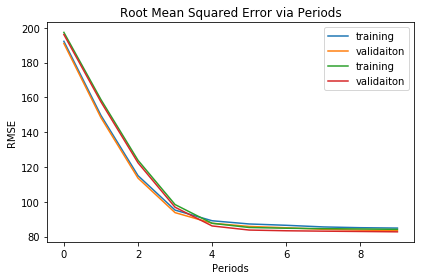

In [41]:
# 使用处理1的特征
kl_features1 = ["distance_to_san_fransico", "median_income"]
kl_training_examples1 = processed_training_examples1[kl_features1]
kl_validation_examples1 = processed_validation_examples1[kl_features1]

_ = train_model(learning_rate=0.01, 
                steps=2000, 
                batch_size=5,
                training_examples=kl_training_examples1, 
                training_targets=training_targets,
               validation_examples=kl_validation_examples1,
               validation_targets=validation_targets)

# 使用处理2的特征
kl_features2 = ["median_income"]
for i in np.arange(32, 42, 1, dtype=np.int):
    feature_name = "latitude_%d_to_%d" % (i, i+1)
    kl_features2.append(feature_name)

kl_training_examples2 = processed_training_examples2[kl_features2]
kl_validation_examples2 = processed_validation_examples2[kl_features2]

_ = train_model(learning_rate=0.01, 
                steps=2000, 
                batch_size=5,
                training_examples=kl_training_examples2, 
                training_targets=training_targets,
               validation_examples=kl_validation_examples2,
               validation_targets=validation_targets)